In [236]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import cartopy.crs as ccrs
import seaborn as sns

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

## Load network and data_generator

In [56]:
args = load_args('../nn_configs/C/017-resnet_d3_ztt_3d.yml')

In [57]:
dg_test = load_data(**args, only_test=True)

In [58]:
X, y = dg_test[0]

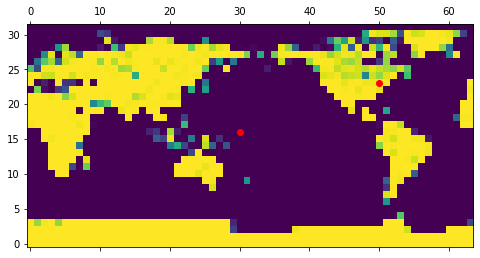

In [59]:
plt.matshow(X[0, ..., -3], origin='lower')
plt.scatter([50], [23], c='r')
plt.scatter([30], [16], c='r')

In [60]:
model = load_model(args)

## For a single sample

In [282]:
lat_london = np.argmin(np.abs(dg_test.data.lat - 51.5074).values)
lon_london = np.argmin(np.abs(dg_test.data.lon - 0.1278).values)

lat_tahiti = np.argmin(np.abs(dg_test.data.lat - 17.65094).values)
lon_tahiti = np.argmin(np.abs(dg_test.data.lon - 149.4260).values)

lat_zero = np.argmin(np.abs(dg_test.data.lat - 0).values)
lon_zero = np.argmin(np.abs(dg_test.data.lon - 0).values)

lat_barb = np.argmin(np.abs(dg_test.data.lat - 13.2).values)
lon_barb = np.argmin(np.abs(dg_test.data.lon - (360 - 59.5)).values)

In [376]:
def compute_grad(model, X, lat_idx, lon_idx, out_idx):

    Xtf = tf.convert_to_tensor(X)
    with tf.GradientTape() as tape:
        tape.watch(Xtf)
        p = model(Xtf)
        point = p[:, lat_idx, lon_idx, out_idx]
    g = tape.gradient(point, Xtf).numpy()[0]

    return g

In [472]:
dg_test_3d.tfrecord_files = None
dg_test_3d.data.load()

<xarray.DataArray 'z' (time: 17520, lat: 32, lon: 64, level: 41)>
array([[[[ 0.59427074, -0.92210999, -0.92460656, ...,  1.44426201,
           2.57085561, -1.67874412],
         [ 0.593702  , -0.92151685, -0.91676586, ...,  1.44426201,
           2.63684811, -1.67874412],
         [ 0.59313326, -0.9209237 , -0.90990482, ...,  1.44426201,
           2.70122081, -1.67874412],
         ...,
         [ 0.59769408, -0.92389084, -0.94322689, ...,  1.44426201,
           2.40688572, -1.67874412],
         [ 0.59598513, -0.92329769, -0.93734666, ...,  1.44426201,
           2.47378905, -1.67874412],
         [ 0.5948422 , -0.92270313, -0.93146643, ...,  1.44426201,
           2.52247395, -1.67874412]],

        [[ 0.50130729, -0.96898814, -1.00399081, ...,  1.44426201,
           2.06275586, -1.57043805],
         [ 0.50130729, -0.9606813 , -0.97360885, ...,  1.44426201,
           2.33441714, -1.57043805],
         [ 0.50187603, -0.95118676, -0.94616701, ...,  1.44426201,
           2.4794585 , -1.57043805],
...
         [-1.39698445, -1.38769501, -1.29018961, ...,  1.06439006,
          -0.28301559,  1.57043805],
         [-1.42443101, -1.41625366, -1.32654883, ..., -0.29933311,
          -0.39848176,  1.57043805],
         [-1.4535974 , -1.44957162, -1.36683833, ..., -0.73436932,
          -0.44373519,  1.57043805]],

        [[-1.47475787, -1.63758393, -1.61742141, ..., -0.73436932,
          -0.44130638,  1.67874412],
         [-1.48390672, -1.65245923, -1.64886602, ..., -0.73436932,
          -0.44110395,  1.67874412],
         [-1.49305557, -1.66792767, -1.6832601 , ..., -0.73436932,
          -0.44080029,  1.67874412],
         ...,
         [-1.44502001, -1.60307544, -1.54372099, ..., -0.73436932,
          -0.43999064,  1.67874412],
         [-1.45531179, -1.61378599, -1.56533872, ..., -0.73436932,
          -0.44191358,  1.67874412],
         [-1.46503483, -1.62449513, -1.58990475, ..., -0.73436932,
          -0.44161007,  1.67874412]]]])
Coordinates:
  * lat          (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon          (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time         (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
  * level        (level) int64 50 250 500 600 700 850 925 50 ... 925 1 1 1 1 1 1
    level_names  (level) <U9 'z_50' 'z_250' 'z_500' ... 'orography' 'lat2d'

In [501]:
dg_test_3d.valid_time[32*3]

<xarray.DataArray 'time' ()>
array('2017-01-08T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-01-08T12:00:00
Attributes:
    long_name:  time

In [497]:
X = dg_test_3d[3][0][:1]
# X = dg_test_3d[2][0][:1]

In [502]:
g_ex = compute_grad(model_3d, X, lat_london, lon_london, 0)

In [499]:
xlabels[77]

'z_250'

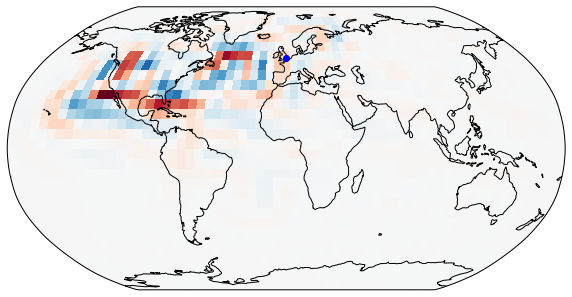

In [503]:
fig = plt.figure(figsize=(10, 6))
p = to_xr(g_ex[..., 77]).plot(
    subplot_kws=dict(projection=ccrs.Robinson()),
    transform=ccrs.PlateCarree(),
    add_colorbar=False,    
)
plt.scatter(0.1278, 51.5074, c='b', transform=ccrs.PlateCarree(), zorder=20)
p.axes.set_global()
p.axes.coastlines();

In [428]:
xlabels = np.concatenate([dg_test.data.level_names.isel(level=dg_test.not_const_idxs).values]*2+[dg_test.data.level_names.values])

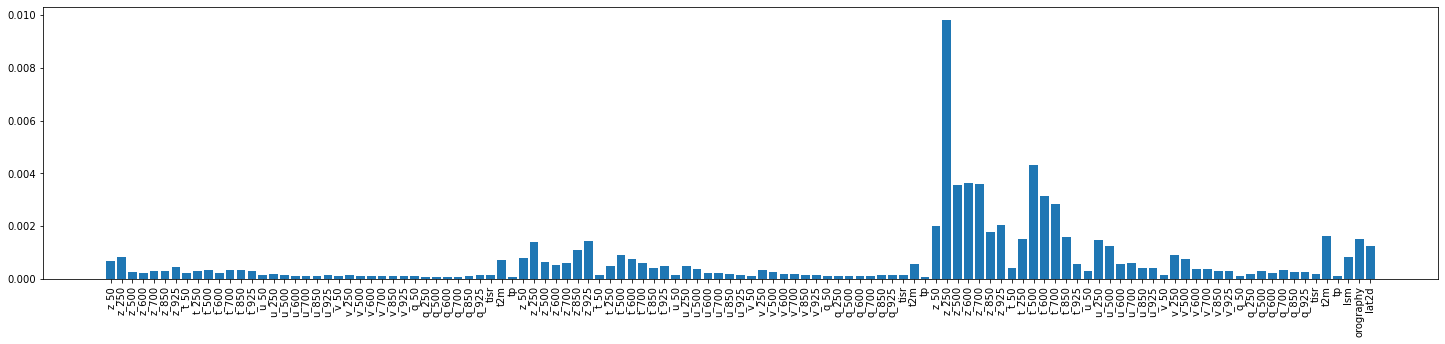

In [429]:
plt.figure(figsize=(25, 5))
plt.bar(np.arange(len(xlabels)), g.std((0, 1)))
plt.xticks(np.arange(len(xlabels)), xlabels, rotation=90);

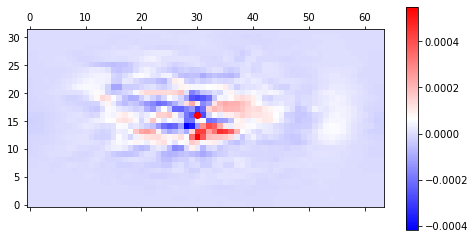

In [68]:
plt.matshow(grads[..., -26], origin='lower', cmap='bwr')
plt.colorbar()
plt.scatter([lon_idx], [lat_idx], c='r')

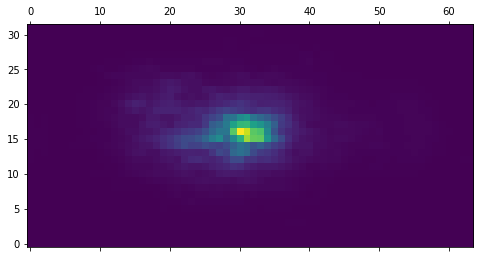

In [69]:
plt.matshow(grads.std(2), origin='lower')

## Over the entire dataset

In [84]:
lat_idx = 16; lon_idx = 30

In [71]:
len(dg_test)

545

In [72]:
dg_test.tfrecord_files

'/data/stephan/WeatherBench/TFR/004-era_all/test/*.tfrecord'

In [91]:
dg_test.n_samples

17448

In [221]:
def compute_saliency(model, dg, lat_idx, lon_idx, out_idx):
    true = []
    grads = np.zeros(dg.shape)
    abss = np.zeros(dg.shape)
    grads2 = np.zeros(dg.shape)
    for X, y in tqdm(dg.tfr_dataset, total=len(dg)):
        Xtf = tf.convert_to_tensor(X)
        with tf.GradientTape() as tape:
            tape.watch(Xtf)
            p = model(Xtf)
            point = p[:, lat_idx, lon_idx, out_idx]
        g = tape.gradient(point, Xtf).numpy()
        true.append(g)
        grads += g.sum(0)
        abss += np.abs(g).sum(0)
        grads2 += (g**2).sum(0)
    grads /= dg.n_samples
    abss /= dg.n_samples
    grads2 /= dg.n_samples
    std = np.sqrt(grads2 - grads**2)
    return grads, std, abss

In [243]:
args_1d = load_args('../nn_configs/C/031-resnet_d3_ztt_1d_pre_no_dr.yml')
dg_test_1d = load_data(**args_1d, only_test=True)
model_1d = load_model(args_1d)

In [244]:
args_3d = load_args('../nn_configs/C/023-resnet_d3_ztt_3d_pre_no_dr.yml')
dg_test_3d = load_data(**args_3d, only_test=True)
model_3d = load_model(args_3d)

In [245]:
args_5d = load_args('../nn_configs/C/034-resnet_d3_ztt_5d_pre_no_dr.yml')
dg_test_5d = load_data(**args_5d, only_test=True)
model_5d = load_model(args_5d)

In [246]:
london_t_mean_1d, london_t_std_1d, london_t_abs_1d = compute_saliency(
    model_1d, dg_test_1d, lat_london, lon_london, out_idx=1
)
london_t_mean_3d, london_t_std_3d, london_t_abs_3d = compute_saliency(
    model_3d, dg_test_3d, lat_london, lon_london, out_idx=1
)
london_t_mean_5d, london_t_std_5d, london_t_abs_5d = compute_saliency(
    model_5d, dg_test_5d, lat_london, lon_london, out_idx=1
)

In [247]:
to_pickle((london_t_mean_1d, london_t_std_1d, london_t_abs_1d), 'london_t_1d.pkl')
to_pickle((london_t_mean_3d, london_t_std_3d, london_t_abs_3d), 'london_t_3d.pkl')
to_pickle((london_t_mean_5d, london_t_std_5d, london_t_abs_5d), 'london_t_5d.pkl')

In [304]:
london_t2m_mean_1d, london_t2m_std_1d, london_t2m_abs_1d = compute_saliency(
    model_1d, dg_test_1d, lat_london, lon_london, out_idx=2
)
london_t2m_mean_3d, london_t2m_std_3d, london_t2m_abs_3d = compute_saliency(
    model_3d, dg_test_3d, lat_london, lon_london, out_idx=2
)
london_t2m_mean_5d, london_t2m_std_5d, london_t2m_abs_5d = compute_saliency(
    model_5d, dg_test_5d, lat_london, lon_london, out_idx=2
)

In [305]:
to_pickle((london_t2m_mean_1d, london_t2m_std_1d, london_t2m_abs_1d), 'london_t2m_1d.pkl')
to_pickle((london_t2m_mean_3d, london_t2m_std_3d, london_t2m_abs_3d), 'london_t2m_3d.pkl')
to_pickle((london_t2m_mean_5d, london_t2m_std_5d, london_t2m_abs_5d), 'london_t2m_5d.pkl')

In [306]:
london_z_mean_1d, london_z_std_1d, london_z_abs_1d = compute_saliency(
    model_1d, dg_test_1d, lat_london, lon_london, out_idx=0
)
london_z_mean_3d, london_z_std_3d, london_z_abs_3d = compute_saliency(
    model_3d, dg_test_3d, lat_london, lon_london, out_idx=0
)
london_z_mean_5d, london_z_std_5d, london_z_abs_5d = compute_saliency(
    model_5d, dg_test_5d, lat_london, lon_london, out_idx=0
)

In [307]:
to_pickle((london_z_mean_1d, london_z_std_1d, london_z_abs_1d), 'london_z_1d.pkl')
to_pickle((london_z_mean_3d, london_z_std_3d, london_z_abs_3d), 'london_z_3d.pkl')
to_pickle((london_z_mean_5d, london_z_std_5d, london_z_abs_5d), 'london_z_5d.pkl')

In [283]:
barb_t_mean_1d, barb_t_std_1d, barb_t_abs_1d = compute_saliency(
    model_1d, dg_test_1d, lat_barb, lon_barb, out_idx=1
)
barb_t_mean_3d, barb_t_std_3d, barb_t_abs_3d = compute_saliency(
    model_3d, dg_test_3d, lat_barb, lon_barb, out_idx=1
)
barb_t_mean_5d, barb_t_std_5d, barb_t_abs_5d = compute_saliency(
    model_5d, dg_test_5d, lat_barb, lon_barb, out_idx=1
)

In [284]:
to_pickle((barb_t_mean_1d, barb_t_std_1d, barb_t_abs_1d), 'barb_t_1d.pkl')
to_pickle((barb_t_mean_3d, barb_t_std_3d, barb_t_abs_3d), 'barb_t_3d.pkl')
to_pickle((barb_t_mean_5d, barb_t_std_5d, barb_t_abs_5d), 'barb_t_5d.pkl')

## Maps

In [248]:
import cartopy.crs as ccrs

In [249]:
def to_xr(a):
    da = xr.DataArray(
        a,
        dims=['lat', 'lon'],
        coords={'lat': dg_test.data.lat, 'lon': dg_test.data.lon}
    )
    return da

In [368]:
X.shape, y.shape

((32, 32, 64, 117), (32, 32, 64, 3))

In [366]:
london_t_abs_1d.shape

(32, 64, 117)

In [251]:
xlabels

array(['z_50', 'z_250', 'z_500', 'z_600', 'z_700', 'z_850', 'z_925',
       't_50', 't_250', 't_500', 't_600', 't_700', 't_850', 't_925',
       'u_50', 'u_250', 'u_500', 'u_600', 'u_700', 'u_850', 'u_925',
       'v_50', 'v_250', 'v_500', 'v_600', 'v_700', 'v_850', 'v_925',
       'q_50', 'q_250', 'q_500', 'q_600', 'q_700', 'q_850', 'q_925',
       'tisr', 't2m', 'tp', 'z_50', 'z_250', 'z_500', 'z_600', 'z_700',
       'z_850', 'z_925', 't_50', 't_250', 't_500', 't_600', 't_700',
       't_850', 't_925', 'u_50', 'u_250', 'u_500', 'u_600', 'u_700',
       'u_850', 'u_925', 'v_50', 'v_250', 'v_500', 'v_600', 'v_700',
       'v_850', 'v_925', 'q_50', 'q_250', 'q_500', 'q_600', 'q_700',
       'q_850', 'q_925', 'tisr', 't2m', 'tp', 'z_50', 'z_250', 'z_500',
       'z_600', 'z_700', 'z_850', 'z_925', 't_50', 't_250', 't_500',
       't_600', 't_700', 't_850', 't_925', 'u_50', 'u_250', 'u_500',
       'u_600', 'u_700', 'u_850', 'u_925', 'v_50', 'v_250', 'v_500',
       'v_600', 'v_700', 'v_

In [254]:
xlabels[78]

'z_500'

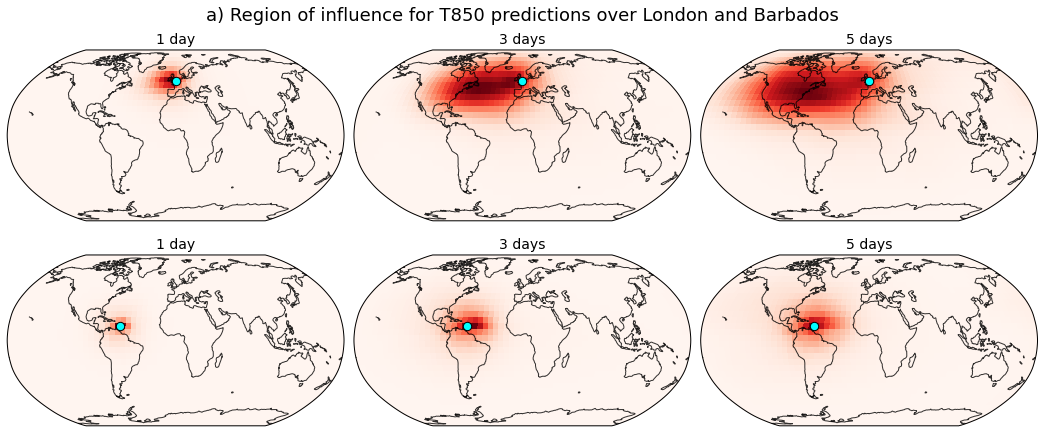

In [559]:
idx = 78
fig, axs = plt.subplots(2, 3, figsize=(15, 6), subplot_kw={'projection': ccrs.Robinson()})
ax1, ax2, ax3, ax4, ax5, ax6 = axs.flatten()
to_xr(london_t_abs_1d.mean(-1)).plot(ax=ax1, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='Reds')
to_xr(london_t_abs_3d.mean(-1)).plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='Reds')
to_xr(london_t_abs_5d.mean(-1)).plot(ax=ax3, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='Reds')

to_xr(barb_t_abs_1d.mean(-1)).plot(ax=ax4, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='Reds')
to_xr(barb_t_abs_3d.mean(-1)).plot(ax=ax5, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='Reds')
to_xr(barb_t_abs_5d.mean(-1)).plot(ax=ax6, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='Reds')


for ax, l in zip(axs.flat, ['1 day', '3 days', '5 days']*2):
    ax.set_global()
    ax.coastlines(alpha=0.8)
    ax.set_title(l, fontsize=14)

for ax in axs[0]:
    ax.scatter(0.1278, 51.5074, c='aqua', transform=ccrs.PlateCarree(), zorder=20, linewidth=1, edgecolor='k', s=70)
for ax in axs[1]:
    ax.scatter(360 - 59.5, 13.2, c='aqua', transform=ccrs.PlateCarree(), zorder=20, linewidth=1, edgecolor='k', s=70)


plt.suptitle('a) Region of influence for T850 predictions over London and Barbados', fontsize=18, y=0.98)
plt.subplots_adjust(left=0.02, right=0.98, wspace=0.01, bottom=0.01)
plt.savefig('./saliency1.png', dpi=200)

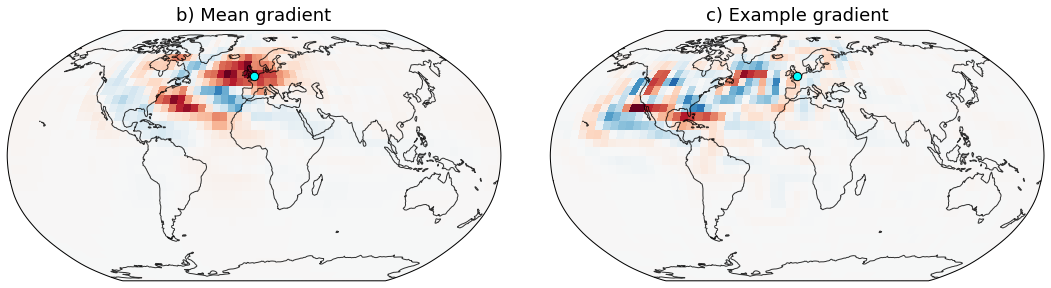

In [560]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4.5), subplot_kw={'projection': ccrs.Robinson()})
p = to_xr(london_t_mean_3d[..., 78]).plot(ax=ax1,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
#     cmap='Reds'
    
)
ax1.scatter(0.1278, 51.5074, c='aqua', transform=ccrs.PlateCarree(), zorder=20, linewidth=1, edgecolor='k', s=70)
ax1.set_title('b) Mean gradient', fontsize=18, pad=10)

p = to_xr(g_ex[..., 77]).plot(ax=ax2,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,    
)
ax2.scatter(0.1278, 51.5074, c='aqua', transform=ccrs.PlateCarree(), zorder=20, linewidth=1, edgecolor='k', s=70)
ax2.set_title('c) Example gradient', fontsize=18, pad=10)
for ax in (ax1, ax2):
    ax.set_global()
    ax.coastlines(alpha=0.8)
    
plt.subplots_adjust(left=0.02, right=0.98, wspace=0.1, bottom=0.01)
fig.savefig('./saliency2.png', dpi=200)

In [ ]:
fig = plt.figure(figsize=(10, 6))
p = to_xr(g_ex[..., 77]).plot(
    subplot_kws=dict(projection=ccrs.Robinson()),
    transform=ccrs.PlateCarree(),
    add_colorbar=False,    
)
plt.scatter(0.1278, 51.5074, c='b', transform=ccrs.PlateCarree(), zorder=20)
p.axes.set_global()
p.axes.coastlines();

In [328]:
xlabels[88]

't_850'

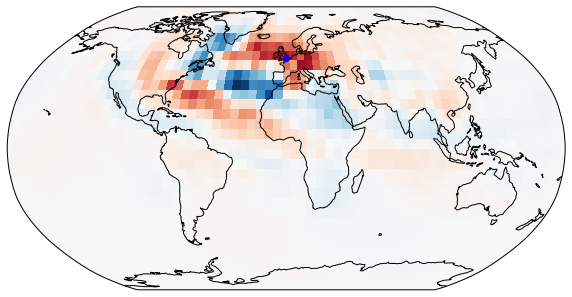

In [329]:
fig = plt.figure(figsize=(10, 6))
p = to_xr(london_z_mean_3d[..., 88]).plot(
    subplot_kws=dict(projection=ccrs.Robinson()),
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
#     cmap='Reds'
    
)
plt.scatter(0.1278, 51.5074, c='b', transform=ccrs.PlateCarree(), zorder=20)
p.axes.set_global()
p.axes.coastlines();

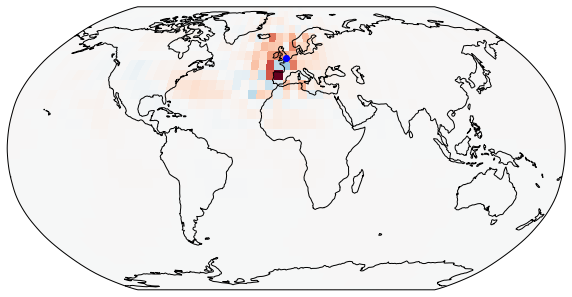

In [364]:
fig = plt.figure(figsize=(10, 6))
p = to_xr(london_t2m_mean_5d[..., 78]).plot(
    subplot_kws=dict(projection=ccrs.Robinson()),
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
#     cmap='Reds'
    
)
plt.scatter(0.1278, 51.5074, c='b', transform=ccrs.PlateCarree(), zorder=20)
p.axes.set_global()
p.axes.coastlines();

In [332]:
xlabels[112]

't2m'

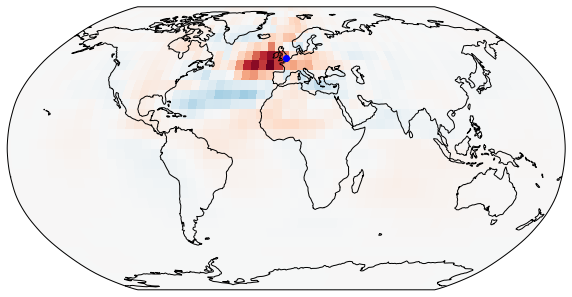

In [363]:
fig = plt.figure(figsize=(10, 6))
p = to_xr(london_z_mean_5d[..., 112]).plot(
    subplot_kws=dict(projection=ccrs.Robinson()),
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
#     cmap='Reds'
    
)
plt.scatter(0.1278, 51.5074, c='b', transform=ccrs.PlateCarree(), zorder=20)
p.axes.set_global()
p.axes.coastlines();

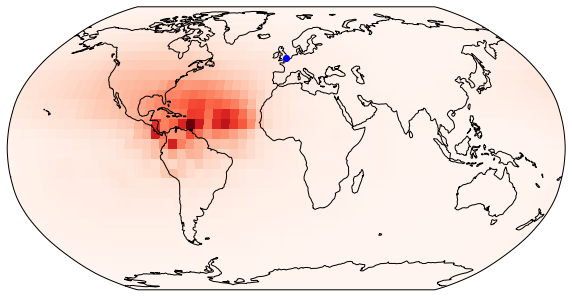

In [358]:
fig = plt.figure(figsize=(10, 6))
p = to_xr(barb_t_abs_5d[..., 78]).plot(
    subplot_kws=dict(projection=ccrs.Robinson()),
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap='Reds'
    
)
plt.scatter(0.1278, 51.5074, c='b', transform=ccrs.PlateCarree(), zorder=20)
p.axes.set_global()
p.axes.coastlines();

In [353]:
xlabels[77]

'z_250'

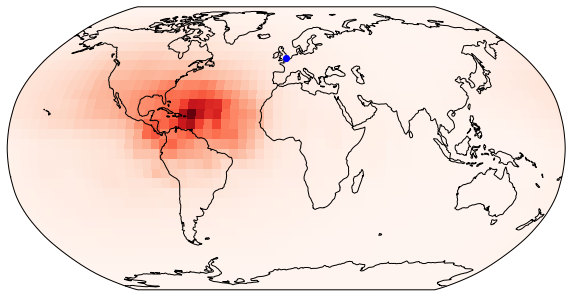

In [359]:
fig = plt.figure(figsize=(10, 6))
p = to_xr(barb_t_abs_5d[..., 77]).plot(
    subplot_kws=dict(projection=ccrs.Robinson()),
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap='Reds'
    
)
plt.scatter(0.1278, 51.5074, c='b', transform=ccrs.PlateCarree(), zorder=20)
p.axes.set_global()
p.axes.coastlines();

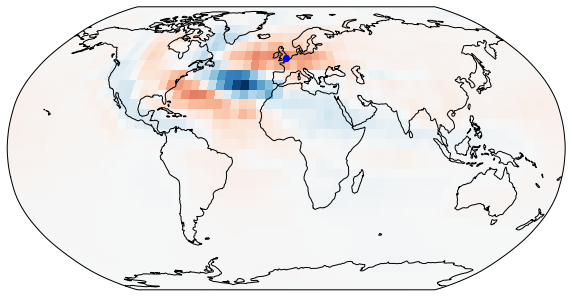

In [320]:
fig = plt.figure(figsize=(10, 6))
p = to_xr(london__mean_3d[..., 78]).plot(
    subplot_kws=dict(projection=ccrs.Robinson()),
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
#     cmap='Reds'
    
)
plt.scatter(0.1278, 51.5074, c='b', transform=ccrs.PlateCarree(), zorder=20)
p.axes.set_global()
p.axes.coastlines();

## Variables

In [334]:
xlabels = np.concatenate([dg_test.data.level_names.isel(level=dg_test.not_const_idxs).values]*2+[dg_test.data.level_names.values])

In [335]:
def to_df(data):
    df = pd.DataFrame(index=dg_test.data.level_names, columns=['-12h', '-6h', '0h'])
    df['-12h'][:38] = data[:38]
    df['-6h'][:38] = data[38:76]
    df['0h'] = data[76:]
    return df

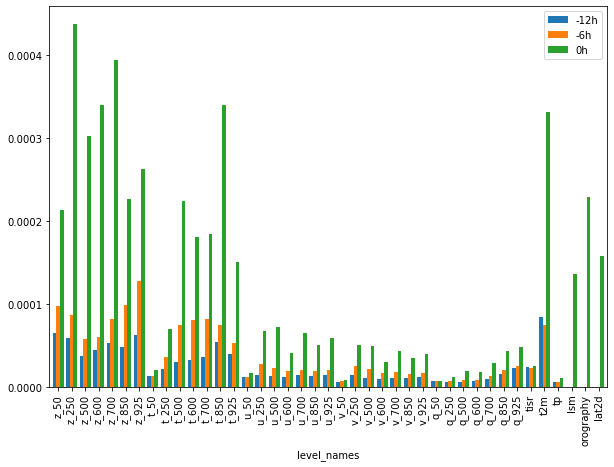

In [360]:
to_df(london_t_abs_1d.mean((0, 1))).plot.bar(figsize=(10, 7), width=0.8)

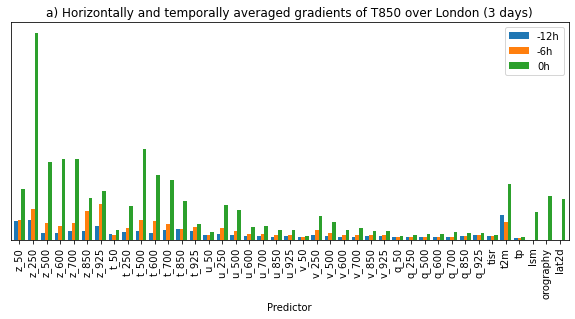

In [570]:
to_df(london_t_abs_3d.mean((0, 1))).plot.bar(figsize=(10, 4), width=0.8)
plt.title('a) Horizontally and temporally averaged gradients of T850 over London (3 days)')
plt.yticks([]);
plt.xlabel('Predictor')
plt.savefig('saliency_bar_london.png', dpi=200, bbox_inches='tight')

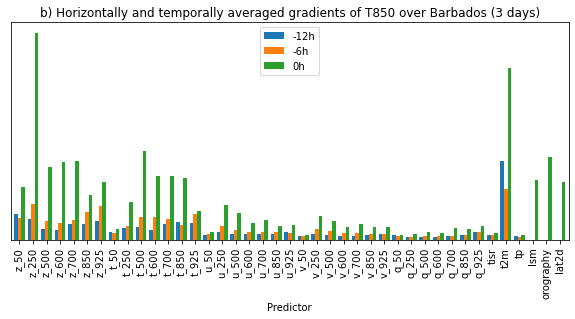

In [569]:
to_df(barb_t_abs_3d.mean((0, 1))).plot.bar(figsize=(10, 4), width=0.8)
plt.title('b) Horizontally and temporally averaged gradients of T850 over Barbados (3 days)')
plt.yticks([]);
plt.xlabel('Predictor')
plt.savefig('saliency_bar_barb.png', dpi=200, bbox_inches='tight')

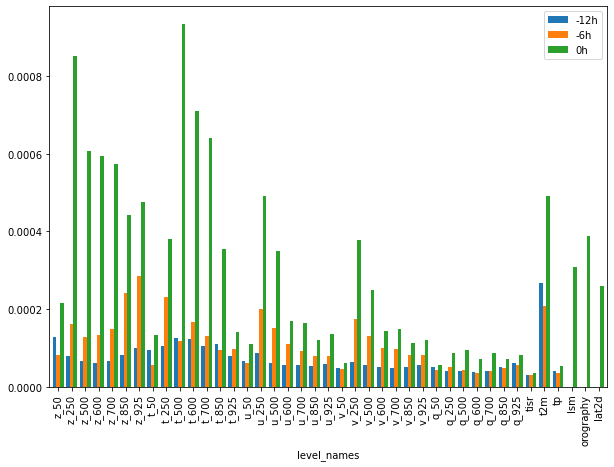

In [362]:
to_df(london_t_abs_5d.mean((0, 1))).plot.bar(figsize=(10, 7), width=0.8)

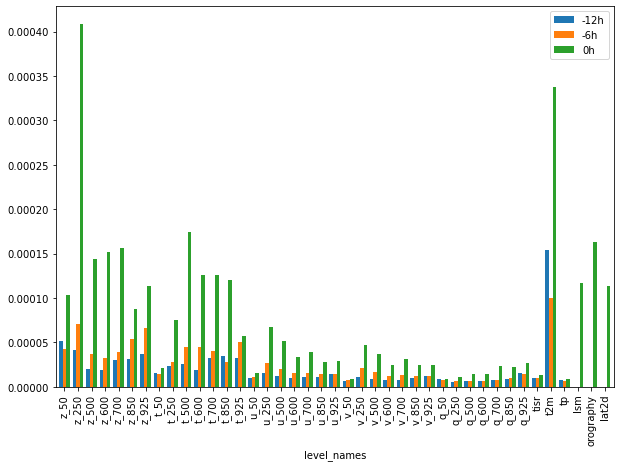

In [350]:
to_df(barb_t_abs_3d.mean((0, 1))).plot.bar(figsize=(10, 7), width=0.8)

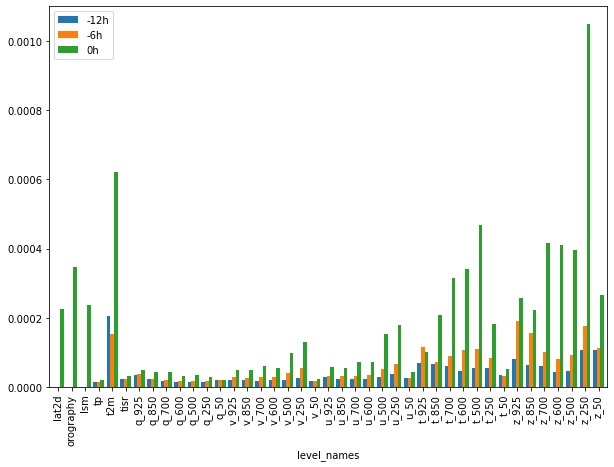

In [346]:
to_df(london_t2m_abs_3d.mean((0, 1)))[::-1].plot.bar(figsize=(10, 7), width=0.8)

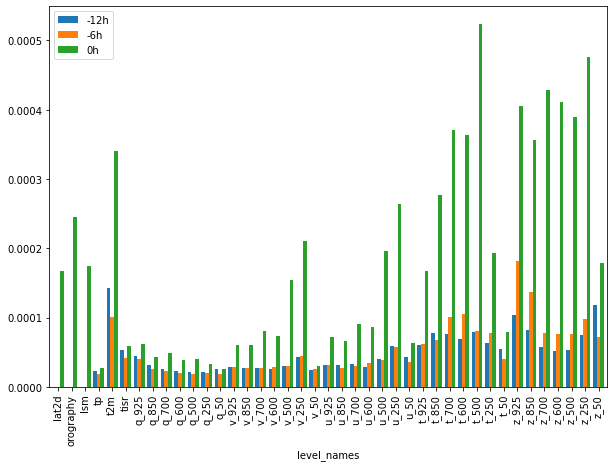

In [340]:
to_df(london_t_abs.mean((0, 1)))[::-1].plot.bar(figsize=(10, 7), width=0.8)

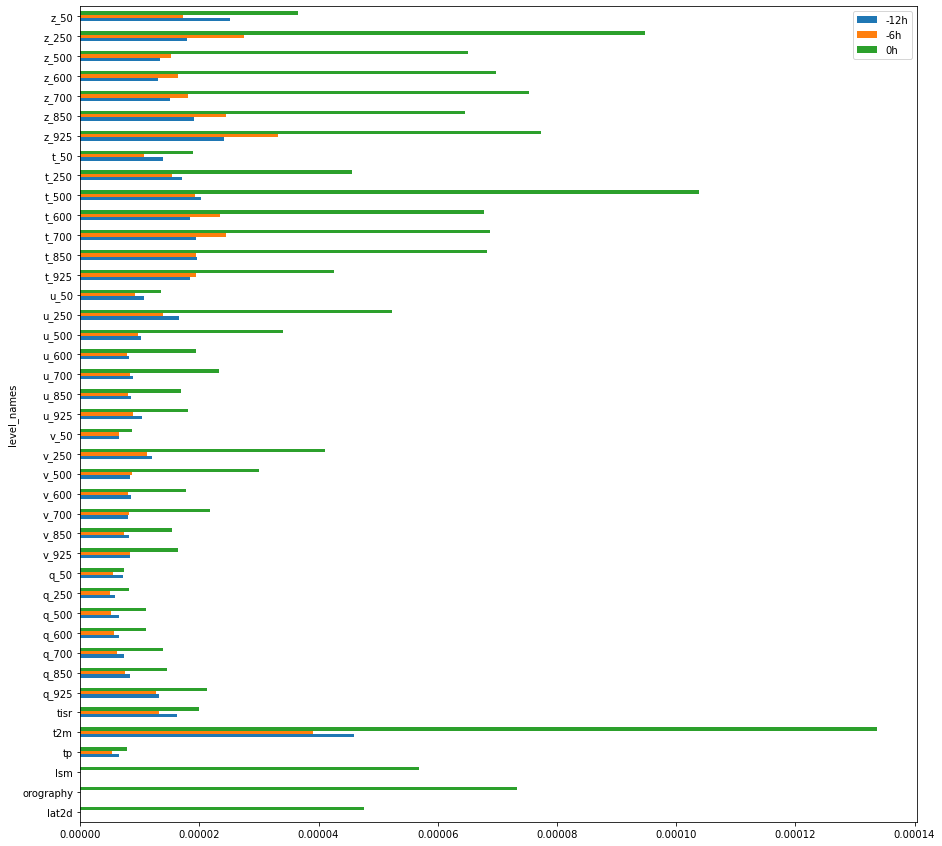

In [198]:
to_df(zero_t_std.mean((0, 1)))[::-1].plot.barh(figsize=(15, 15))

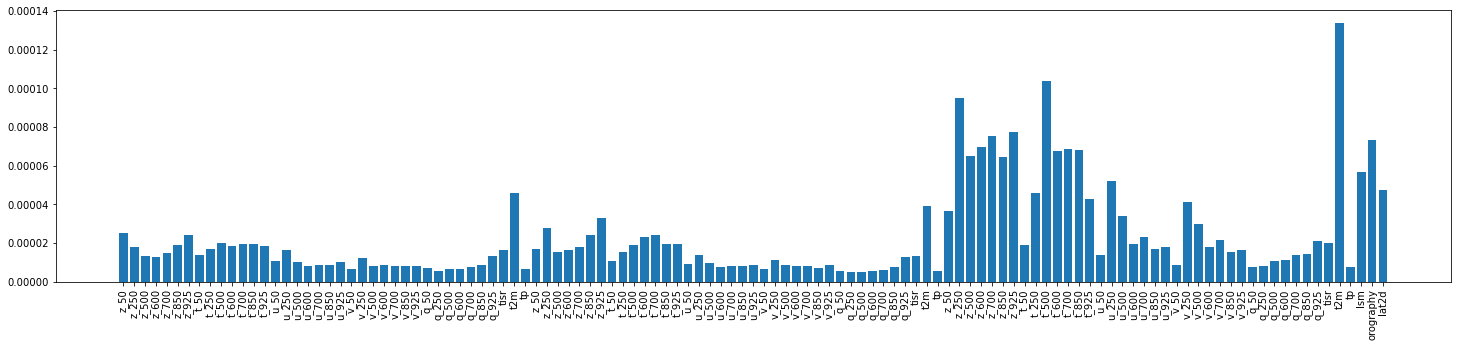

In [180]:
plt.figure(figsize=(25, 5))
plt.bar(np.arange(len(xlabels)), zero_t_std.mean((0, 1)))
plt.xticks(np.arange(len(xlabels)), xlabels, rotation=90);